In [2]:
from torchdyn.models import *
from torchdyn.datasets import *
from torchdyn import *
import torchdyn

In [94]:
from torch.autograd import grad
from torch import nn
import torch

class LNN(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L # model
    
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2 # x (bs, 2D) D in q dim
            qqd = x.requires_grad_(True) # [bs, q qd]
            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0]
            DL_q, DL_qd = J[:, :n], J[:, n:]
            DDL_qd = [] #hessian
            for i in range(n):
                J_qd_i = DL_qd[:, i][:, None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:]) # (bs, q, qd) * (bs, qd)
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T)
            
        return torch.cat([qqd[:,self.n:], qdd], 1)

    def _lagrangian(self, qqd):
        return self.L(qqd)

In [4]:
class ControlledLNN(nn.Module):
    def __init__(self, L, x_dim, input_matrix = nn.Identity()):
        super().__init__()
        self.L = L # model
        self.x_dim = x_dim
        self.input_matrix = input_matrix
        self.input_matrix.requires_grad_(False)        
    
    def forward(self, xu):
        with torch.set_grad_enabled(True):
            self.n = n = self.x_dim // 2  # x (bs, 2D) D in q dim
            xu = xu.requires_grad_(True)

            qqd = xu[:, :self.x_dim]
            u = xu[:, self.x_dim:]

            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0]
            DL_q, DL_qd = J[:, :n], J[:, n:]
            DDL_qd = [] #hessian
            for i in range(n):
                J_qd_i = DL_qd[:, i][:, None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:]) # (bs, q, qd) * (bs, qd)
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.pinverse(), DL_q - T - self.input_matrix(u))

        return torch.cat([qqd[:,self.n:], qdd, torch.zeros_like(u)], 1)

    def _lagrangian(self, qqd):
        return self.L(qqd)

In [5]:
class IntegralControlledLNN(nn.Module):
    def __init__(self, L, x_dim, input_matrix = nn.Identity(), sampling_time=0.01, discrete_time=0.001):
        super().__init__()
        self.L = L # model
        self.x_dim = x_dim
        self.input_matrix = input_matrix
        self.input_matrix.requires_grad_(False)
        self.sampling_time = sampling_time
        self.discrete_time = discrete_time
    
    def forward(self, xu):
        with torch.set_grad_enabled(True):
            self.n = n = self.x_dim // 2  # x (bs, 2D) D in q dim
            xu = xu.requires_grad_(True)

            qqd = xu[:, :self.x_dim]
            u = xu[:, self.x_dim:]

            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0]
            DL_q, DL_qd = J[:, :n], J[:, n:]
            DDL_qd = [] #hessian
            for i in range(n):
                J_qd_i = DL_qd[:, i][:, None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:]) # (bs, q, qd) * (bs, qd)
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.pinverse(), DL_q - T + self.input_matrix(u))

        return torch.cat([qqd[:,self.n:], qdd, torch.zeros_like(u)], 1)
    
    def discrete_predict(self, xu):
        def func(order, xu):
            return self.forward(xu)
        sol = torchdyn.odeint(func, xu, torch.linspace(0, sampling_dt, int(sampling_dt/discrete_dt)))

        return sol[-1]

    def _lagrangian(self, qqd):
        return self.L(qqd)

In [ ]:
from Delan_test import DeepLagrangianNetwork


In [35]:
import torch.utils.data as data
device = torch.device("cpu")

m, k, l = 1, 1, 1

dataset = 100 * 1000  

noise = torch.Tensor(dataset, 1).normal_(0, 0.1).to(device) 

X = torch.Tensor(dataset, 1).uniform_(-1, 1).to(device) + noise
dX = torch.Tensor(dataset, 1).uniform_(-1, 1).to(device) + noise
U = torch.Tensor(dataset, 1).uniform_(-0.1, 0.1).to(device) + noise
Xdd = -k*X/m + U

X_Xd_U = torch.cat([X, dX, U], axis=1)
Xd_Xdd_dU = torch.cat([dX, Xdd, torch.zeros_like(U)], axis=1)
train = data.TensorDataset(X_Xd_U, Xd_Xdd_dU)
trainloader = data.DataLoader(train, batch_size=64, shuffle=False, num_workers=8, drop_last=True)

print(X_Xd_U)
print(Xd_Xdd_dU.shape)
# print(XdXddU.shape)


tensor([[-0.7486, -0.3459, -0.1291],
        [ 0.4558,  0.6695,  0.0192],
        [-1.0568, -0.2308, -0.0177],
        ...,
        [ 0.3511, -0.1374, -0.2230],
        [ 0.7367, -0.0336,  0.0472],
        [ 1.2433,  0.1683,  0.2959]])
torch.Size([100000, 3])


In [36]:
def mass_spring(t, xu):
    x, dx, u = torch.split(xu, 1, 1)
    m, k, l = 1, 1, 1
    ddx = -k*x/m + u/m

    return torch.cat([dx, ddx, torch.zeros_like(u)], axis=1)

In [162]:
import numpy as np

sampling_dt = 0.01
discrete_dt = 0.001

sol = torchdyn.odeint(mass_spring, X_Xd_U, torch.linspace(0, sampling_dt, int(sampling_dt/discrete_dt)))

observation = sol[-1]

Xd_Xdd_dU = (observation - X_Xd_U) / sampling_dt
print(Xd_Xdd_dU[1])
train = data.TensorDataset(X_Xd_U, Xd_Xdd_dU)
trainloader = data.DataLoader(train, batch_size=64, shuffle=False, num_workers=8)

torch.Size([100000, 3])
torch.Size([100000, 3])
tensor([ 0.6673, -0.4400,  0.0000])


In [38]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model.defunc(0, x)

    def loss(self, y_hat, y): # predict, target
        return ((y - y_hat)**2).mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model.defunc(0, x) #static training: we do not solve the ODE
        loss = self.loss(y_hat, y)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train_dataloader(self):
        return trainloader

In [39]:
# hdim = 128
# net = LNN(nn.Sequential(
#             nn.Linear(2,hdim),
#             nn.Softplus(),
#             nn.Linear(hdim,hdim),
#             nn.Softplus(),
#             nn.Linear(hdim,1))
#          ).to(device)

# hdim = 128
# net = ControlledLNN(
#             nn.Sequential(
#             nn.Linear(2,hdim),
#             nn.Softplus(),
#             nn.Linear(hdim,hdim),
#             nn.Softplus(),
#             nn.Linear(hdim,1)),
#             2,
#          ).to(device)
hdim = 128
net = IntegralControlledLNN(
            nn.Sequential(
            nn.Linear(2,hdim),
            nn.Softplus(),
            nn.Linear(hdim,hdim),
            nn.Softplus(),
            nn.Linear(hdim,1)),
            2,
         ).to(device)
model = NeuralDE(func=net, solver='dopri5').to(device)

In [40]:
model.defunc.m.discrete_predict(torch.ones(2,3))

tensor([[1.0223, 3.9579, 1.0000],
        [1.0223, 3.9579, 1.0000]], grad_fn=<SelectBackward>)

In [41]:

learn = Learner(model)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/dhsung/anaconda3/envs/general/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 17.0 K
-----------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)
Epoch 5:  24%|██▎       | 370/1563 [00:08<00:28, 41.89it/s, loss=9.64e-05, v_num=27]/home/dhsung/anaconda3/envs/general/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [43]:
import time
t = time.time()
model.nfe = 0
size = 256

noise = torch.Tensor(size, 1).normal_(0, 0.1).to(device) 
X0 = torch.Tensor(size, 2).uniform_(-1,1).to(device) + noise
zero_force = torch.zeros(size, 1)

XU0 = torch.cat([X0, zero_force], axis=1)

s_span = torch.linspace(0, 10, 100)
traj = model.trajectory(XU0, s_span).cpu().detach()
T = time.time() - t
print(f"NFE: {model.nfe}\ninference time: {T}\navg time per function evaluation: {T/model.nfe}")

NFE: 80
inference time: 0.9011261463165283
avg time per function evaluation: 0.011264076828956604


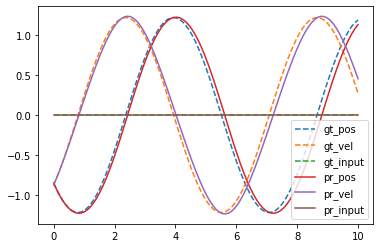

In [45]:
from scipy.integrate import odeint
index = 100

plt.plot(s_span, sol[:,index, 0],"--")
plt.plot(s_span, sol[:,index, 1],"--")
plt.plot(s_span, sol[:, index,2],"--")

plt.plot(s_span, traj[:, index, 0])
plt.plot(s_span, traj[:, index, 1])
plt.plot(s_span, traj[:, index, 2])
plt.legend(["gt_pos", "gt_vel", "gt_input"]+ ["pr_pos", "pr_vel", "pr_input"])
# plt.legend()
plt.show()

In [ ]:

plt.show()


(1.0, 2.0)

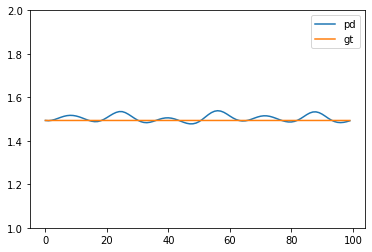

In [53]:
plt.plot(traj[:, index ,0].t() * traj[:, index ,0] + traj[:, index ,1].t() * traj[:, index ,1])
plt.plot(sol[:, index ,0].t() * sol[:, index ,0] + sol[:, index ,1].t() * sol[:, index ,1])
plt.legend(["pd", "gt"])
plt.ylim([1,2])

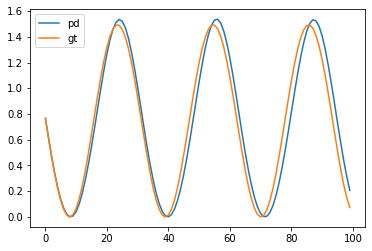

In [50]:
#kinetic
plt.plot(traj[:, index ,1].t() * traj[:, index ,1])
plt.plot(sol[:, index ,1].t() * sol[:, index ,1])
plt.legend(["pd", "gt"])


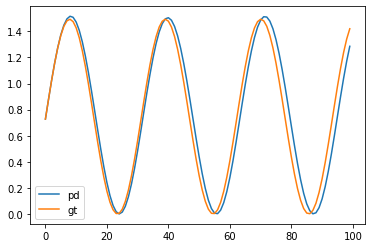

In [49]:
#potential
plt.plot(traj[:, index ,0].t() * traj[:, index ,0])
plt.plot(sol[:, index ,0].t() * sol[:, index ,0])
plt.legend(["pd", "gt"])


In [159]:
#jacobian
from torch.autograd.functional import jacobian, jvp

xu = 2*torch.ones(2, 3)
q = 1
u = 1

batch = 0
# f_start = model.defunc.m.forward(xu)

f_start, xu_grad = jvp(model.defunc.m.forward, xu,  xu, create_graph=True, strict=True)
AB = jacobian(model.defunc.m.forward, xu, create_graph=True, strict=True)[batch, q:2*q, batch, :]

c = f_start[batch] - AB @ xu[batch] # I would choose this one
c1 = f_start[batch] - xu_grad[batch]

print(AB.detach())
print(f_start[batch].detach())
print(c.detach(), c1.detach())
xu_new = xu + 0.1*torch.randn(2, 3)
print(model.defunc.m.forward(xu_new)[batch], AB @ (xu_new[batch] - xu[batch]) + f_start[batch])
print(model.defunc.m.forward(xu_new)[batch], AB @ xu_new[batch] + c1)


tensor([[-0.5525,  0.2493,  1.4337]])
tensor([2.0000, 0.6654, 0.0000])
tensor([-0.2611, -1.5957, -2.2611]) tensor([ 0.0000, -1.5957,  0.0000])
tensor([1.9787, 0.6638, 0.0000], grad_fn=<SelectBackward>) tensor([ 1.9984e+00,  6.6378e-01, -1.6144e-03], grad_fn=<AddBackward0>)
tensor([1.9787, 0.6638, 0.0000], grad_fn=<SelectBackward>) tensor([2.2595, 0.6638, 2.2595], grad_fn=<AddBackward0>)


In [122]:
def cus_func(x):
    return torch.exp(x)

In [133]:
X = torch.zeros(1, 1)
jac_X = jacobian(cus_func, X, create_graph=False)
f_start = cus_func(X)
Y = torch.ones(1,1)
jacobian_vector_product = jvp(cus_func, X,  X, create_graph=True)[1]
print(jacobian_vector_product)
print(jac_X @ X)



tensor([[0.]], grad_fn=<MulBackward0>)
tensor([[[[0.]]]])


In [180]:
inputs = xu[1:2]
jacobian(model.defunc.m.forward, inputs).squeeze()

tensor([[ 0.0000,  1.0000,  0.0000],
        [-0.5525,  0.2493,  1.4337],
        [ 0.0000,  0.0000,  0.0000]])

In [1]:
import torch
import torch.utils.data as data

In [21]:
batch = 10
train = data.TensorDataset(torch.ones(batch, 1), torch.ones(batch, 2, 2), torch.ones(batch, 2, 3))
loader = data.DataLoader(train, batch_size=10, shuffle=True)

In [ ]:
for i, data in enumerate(loader):
    print(data)